# PETSc ARG

## Setup

First, check if you are at the correct project environment.

In [ ]:
using Pkg
Pkg.status()

Then check if all packages are installed and up to date:

In [ ]:
Pkg.update()

In [1]:
using ExperimentalDesign, StatsModels, GLM, DataFrames, Distributions, Random, StatsPlots

# Designs with Categorical Factors

In [2]:
design_distribution = DesignDistribution((ksp_type = CategoricalFactor(["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]),
        pc_type = CategoricalFactor(["jacobi", "sor", "bjacobi", "mg"])))

DesignDistribution
Formula: 0 ~ ksp_type + pc_type
Factor Distributions:
ksp_type: CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)

pc_type: CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)


In [3]:
design = rand(design_distribution, 300)
f = @formula 0 ~ ksp_type + pc_type
optimal_design = OptimalDesign(design, f, 10)

OptimalDesign
Dimension: (10, 2)
Factors: (ksp_type = CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)
, pc_type = CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)
)
Formula: 0 ~ ksp_type + pc_type
Selected Candidate Rows: [198, 218, 197, 243, 228, 255, 160, 4, 62, 11]
Optimality Criteria: Dict(:D => 0.004242513689067568)
Design Matrix:
10×2 DataFrame
│ Row │ ksp_type │ pc_type │
│     │ String   │ String  │
├─────┼──────────┼─────────┤
│ 1   │ cg       │ jacobi  │
│ 2   │ cg       │ sor     │
│ 3   │ tcqmr    │ mg      │
│ 4   │ tfqmr    │ mg      │
│ 5   │ cgs      │ bjacobi │
│ 6   │ bcgs     │ sor     │
│ 7   │ cr       │ bjacobi │
│ 8   │ gcr      │ bjacobi │
│ 9   │ gmres    │ mg      │
│ 10  │ fcg      │ mg      │

Plot design

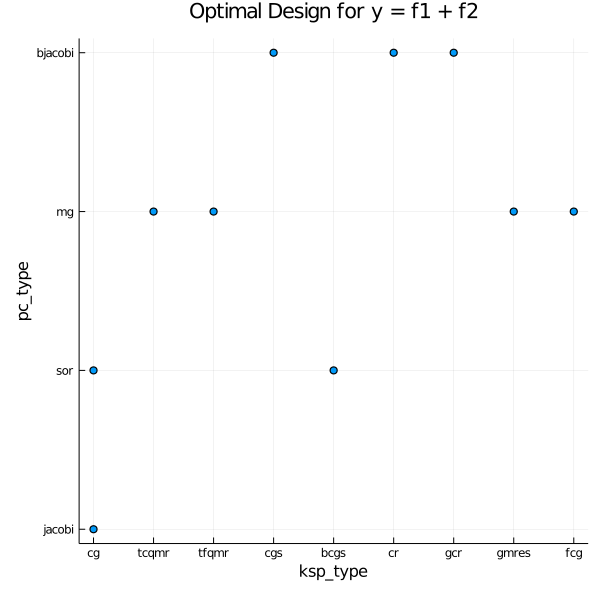

In [4]:
@df optimal_design.matrix scatter(:ksp_type,
    :pc_type,
    size = (600, 600),
    xlabel = "ksp_type",
    ylabel = "pc_type",
    legend = false,
    title = "Optimal Design for y = f1 + f2")

## Target Application Parameters

In [5]:
# Command prefix
cmd_prefix = "singularity exec --nv ./petsc-gpu make"

# Where to run {core,cuda,thread}
dev = "core"

# Number of processes
np = 4

# Mesh resolution
res = 100

100

## Response Function

In [6]:
# x is a set of flags
function y(x)
    parameters = ""
    for i in 1:length(x)
        parameters = string(parameters, uppercase(string(keys(x)[i])), "=", x[i], " ")
    end
    parameters = rstrip(parameters)
    
    # Erro na interpolação na string. A Julia está colocando aspas simples em volta das variáveis.
    #cmd = `$cmd_prefix $dev NP=$np RES=$res $parameters`
        
    # Como deveria ficar:
    cmd = `singularity exec --nv ./petsc-gpu make core NP=4 RES=100 KSP_TYPE=tfqmr PC_TYPE=bjacobi`

    exec_time = @elapsed run(cmd)
    return exec_time
end

y (generic function with 1 method)

In [7]:
optimal_design.matrix[!, :response] = y.(eachrow(optimal_design.matrix))

/opt/petsc/arch-linux2-c-opt/bin/mpirun -np 4 --map-by core --display-map ./solver -m 100 -n 100 -mat_type aij -ksp_type tfqmr -pc_type bjacobi -log_view
 Data for JOB [32178,1] offset 0 Total slots allocated 4

 ========================   JOB MAP   ========================

 Data for node: dell	Num slots: 4	Max slots: 0	Num procs: 4
 	Process OMPI jobid: [32178,1] App: 0 Process rank: 0 Bound: socket 0[core 0[hwt 0-1]]:[BB/../../..]
 	Process OMPI jobid: [32178,1] App: 0 Process rank: 1 Bound: socket 0[core 1[hwt 0-1]]:[../BB/../..]
 	Process OMPI jobid: [32178,1] App: 0 Process rank: 2 Bound: socket 0[core 2[hwt 0-1]]:[../../BB/..]
 	Process OMPI jobid: [32178,1] App: 0 Process rank: 3 Bound: socket 0[core 3[hwt 0-1]]:[../../../BB]

Norm of error 0.000564104 iterations 50
************************************************************************************************************************
***             WIDEN YOUR WINDOW TO 120 CHARACTERS.  Use 'enscript -r -fCourier9' to print th

PCSetUp                2 1.0 8.3046e-03 1.0 2.66e+04 1.0 0.0e+00 0.0e+00 0.0e+00  6  0  0  0  0   6  0  0  0  0    13       0      0 0.00e+00    0 0.00e+00  0
PCSetUpOnBlocks        1 1.0 3.4888e-03 1.0 2.66e+04 1.0 0.0e+00 0.0e+00 0.0e+00  2  0  0  0  0   2  0  0  0  0    31       0      0 0.00e+00    0 0.00e+00  0
PCApply              101 1.0 1.6360e-02 1.0 2.22e+06 1.0 0.0e+00 0.0e+00 0.0e+00 12 29  0  0  0  12 29  0  0  0   543       0      0 0.00e+00    0 0.00e+00  0
---------------------------------------------------------------------------------------------------------------------------------------------------------------

Memory usage is given in bytes:

Object Type          Creations   Destructions     Memory  Descendants' Mem.
Reports information only for process 0.

--- Event Stage 0: Main Stage

              Matrix     4              4       600108     0.
         Vec Scatter     1              1          816     0.
              Vector    16             16       268064   


Using C compiler: /opt/petsc/arch-linux2-c-opt/bin/mpicc  -fPIC -Wall -Wwrite-strings -Wno-strict-aliasing -Wno-unknown-pragmas -fstack-protector -fvisibility=hidden -fopenmp   
Using Fortran compiler: /opt/petsc/arch-linux2-c-opt/bin/mpif90  -fPIC -Wall -ffree-line-length-0 -Wno-unused-dummy-argument -fopenmp    
-----------------------------------------

Using include paths: -I/opt/petsc/include -I/opt/petsc/arch-linux2-c-opt/include -I/usr/local/cuda/include
-----------------------------------------

Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-l

Configure options: --with-debugging=no --with-openmp=1 --with-cuda=1 --download-superlu_dist --download-mumps --download-hypre --download-scalapack --download-spai --download-parms --download-slepc --download-openmpi=yes --download-openmpi-configure-arguments=--with-cuda=/usr/local/cuda CUDAOPTFLAGS= COPTFLAGS= CXXOPTFLAGS= FOPTFLAGS=
-----------------------------------------
Libraries compiled on 2020-08-02 15:41:14 on petsc-gpu 
Machine characteristics: Linux-5.4.0-42-generic-x86_64-with-debian-10.5
Using PETSc directory: /opt/petsc
Using PETSc arch: arch-linux2-c-opt
-----------------------------------------

Using C compiler: /opt/petsc/arch-linux2-c-opt/bin/mpicc  -fPIC -Wall -Wwrite-strings -Wno-strict-aliasing -Wno-unknown-pragmas -fstack-protector -fvisibility=hidden -fopenmp   
Using Fortran compiler: /opt/petsc/arch-linux2-c-opt/bin/mpif90  -fPIC -Wall -ffree-line-length-0 -Wno-unused-dummy-argument -fopenmp    
-----------------------------------------

Using include paths: 

Configure options: --with-debugging=no --with-openmp=1 --with-cuda=1 --download-superlu_dist --download-mumps --download-hypre --download-scalapack --download-spai --download-parms --download-slepc --download-openmpi=yes --download-openmpi-configure-arguments=--with-cuda=/usr/local/cuda CUDAOPTFLAGS= COPTFLAGS= CXXOPTFLAGS= FOPTFLAGS=
-----------------------------------------
Libraries compiled on 2020-08-02 15:41:14 on petsc-gpu 
Machine characteristics: Linux-5.4.0-42-generic-x86_64-with-debian-10.5
Using PETSc directory: /opt/petsc
Using PETSc arch: arch-linux2-c-opt
-----------------------------------------

Using C compiler: /opt/petsc/arch-linux2-c-opt/bin/mpicc  -fPIC -Wall -Wwrite-strings -Wno-strict-aliasing -Wno-unknown-pragmas -fstack-protector -fvisibility=hidden -fopenmp   
Using Fortran compiler: /opt/petsc/arch-linux2-c-opt/bin/mpif90  -fPIC -Wall -ffree-line-length-0 -Wno-unused-dummy-argument -fopenmp    
-----------------------------------------

Using include paths: 

Configure options: --with-debugging=no --with-openmp=1 --with-cuda=1 --download-superlu_dist --download-mumps --download-hypre --download-scalapack --download-spai --download-parms --download-slepc --download-openmpi=yes --download-openmpi-configure-arguments=--with-cuda=/usr/local/cuda CUDAOPTFLAGS= COPTFLAGS= CXXOPTFLAGS= FOPTFLAGS=
-----------------------------------------
Libraries compiled on 2020-08-02 15:41:14 on petsc-gpu 
Machine characteristics: Linux-5.4.0-42-generic-x86_64-with-debian-10.5
Using PETSc directory: /opt/petsc
Using PETSc arch: arch-linux2-c-opt
-----------------------------------------

Using C compiler: /opt/petsc/arch-linux2-c-opt/bin/mpicc  -fPIC -Wall -Wwrite-strings -Wno-strict-aliasing -Wno-unknown-pragmas -fstack-protector -fvisibility=hidden -fopenmp   
Using Fortran compiler: /opt/petsc/arch-linux2-c-opt/bin/mpif90  -fPIC -Wall -ffree-line-length-0 -Wno-unused-dummy-argument -fopenmp    
-----------------------------------------

Using include paths: 

/opt/petsc/arch-linux2-c-opt/bin/mpirun -np 4 --map-by core --display-map ./solver -m 100 -n 100 -mat_type aij -ksp_type tfqmr -pc_type bjacobi -log_view
 Data for JOB [29594,1] offset 0 Total slots allocated 4

 ========================   JOB MAP   ========================

 Data for node: dell	Num slots: 4	Max slots: 0	Num procs: 4
 	Process OMPI jobid: [29594,1] App: 0 Process rank: 0 Bound: socket 0[core 0[hwt 0-1]]:[BB/../../..]
 	Process OMPI jobid: [29594,1] App: 0 Process rank: 1 Bound: socket 0[core 1[hwt 0-1]]:[../BB/../..]
 	Process OMPI jobid: [29594,1] App: 0 Process rank: 2 Bound: socket 0[core 2[hwt 0-1]]:[../../BB/..]
 	Process OMPI jobid: [29594,1] App: 0 Process rank: 3 Bound: socket 0[core 3[hwt 0-1]]:[../../../BB]

Norm of error 0.000564104 iterations 50
************************************************************************************************************************
***             WIDEN YOUR WINDOW TO 120 CHARACTERS.  Use 'enscript -r -fCourier9' to print th


Using C compiler: /opt/petsc/arch-linux2-c-opt/bin/mpicc  -fPIC -Wall -Wwrite-strings -Wno-strict-aliasing -Wno-unknown-pragmas -fstack-protector -fvisibility=hidden -fopenmp   
Using Fortran compiler: /opt/petsc/arch-linux2-c-opt/bin/mpif90  -fPIC -Wall -ffree-line-length-0 -Wno-unused-dummy-argument -fopenmp    
-----------------------------------------

Using include paths: -I/opt/petsc/include -I/opt/petsc/arch-linux2-c-opt/include -I/usr/local/cuda/include
-----------------------------------------

Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-l


Using C compiler: /opt/petsc/arch-linux2-c-opt/bin/mpicc  -fPIC -Wall -Wwrite-strings -Wno-strict-aliasing -Wno-unknown-pragmas -fstack-protector -fvisibility=hidden -fopenmp   
Using Fortran compiler: /opt/petsc/arch-linux2-c-opt/bin/mpif90  -fPIC -Wall -ffree-line-length-0 -Wno-unused-dummy-argument -fopenmp    
-----------------------------------------

Using include paths: -I/opt/petsc/include -I/opt/petsc/arch-linux2-c-opt/include -I/usr/local/cuda/include
-----------------------------------------

Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-l


Using C linker: /opt/petsc/arch-linux2-c-opt/bin/mpicc
Using Fortran linker: /opt/petsc/arch-linux2-c-opt/bin/mpif90
Using libraries: -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -lpetsc -Wl,-rpath,/opt/petsc/arch-linux2-c-opt/lib -L/opt/petsc/arch-linux2-c-opt/lib -Wl,-rpath,/usr/local/cuda/lib64 -L/usr/local/cuda/lib64 -Wl,-rpath,/usr/lib/gcc/x86_64-linux-gnu/8 -L/usr/lib/gcc/x86_64-linux-gnu/8 -Wl,-rpath,/usr/lib/x86_64-linux-gnu -L/usr/lib/x86_64-linux-gnu -Wl,-rpath,/lib/x86_64-linux-gnu -L/lib/x86_64-linux-gnu -lHYPRE -lcmumps -ldmumps -lsmumps -lzmumps -lmumps_common -lpord -lscalapack -lsuperlu_dist -lparms -lspai -llapack -lblas -lX11 -lm -lcufft -lcublas -lcudart -lcusparse -lcusolver -lstdc++ -ldl -lmpi_usempif08 -lmpi_usempi_ignore_tkr -lmpi_mpifh -lmpi -lgfortran -lm -lgfortran -lm -lgcc_s -lquadmath -lpthread -lstdc++ -ldl
-----------------------------------------

/opt/petsc/arch-linux2-c-opt/bin/mpirun -np 4 --map-by core --display-map

Configure options: --with-debugging=no --with-openmp=1 --with-cuda=1 --download-superlu_dist --download-mumps --download-hypre --download-scalapack --download-spai --download-parms --download-slepc --download-openmpi=yes --download-openmpi-configure-arguments=--with-cuda=/usr/local/cuda CUDAOPTFLAGS= COPTFLAGS= CXXOPTFLAGS= FOPTFLAGS=
-----------------------------------------
Libraries compiled on 2020-08-02 15:41:14 on petsc-gpu 
Machine characteristics: Linux-5.4.0-42-generic-x86_64-with-debian-10.5
Using PETSc directory: /opt/petsc
Using PETSc arch: arch-linux2-c-opt
-----------------------------------------

Using C compiler: /opt/petsc/arch-linux2-c-opt/bin/mpicc  -fPIC -Wall -Wwrite-strings -Wno-strict-aliasing -Wno-unknown-pragmas -fstack-protector -fvisibility=hidden -fopenmp   
Using Fortran compiler: /opt/petsc/arch-linux2-c-opt/bin/mpif90  -fPIC -Wall -ffree-line-length-0 -Wno-unused-dummy-argument -fopenmp    
-----------------------------------------

Using include paths: 

10-element Array{Float64,1}:
 12.347038535
  1.88054543
  1.782023085
  1.816745104
  1.88112558
  1.838998567
  1.88576356
  1.811397075
  1.744706286
  1.766574188

In [8]:
print(optimal_design)

OptimalDesign
Dimension: (10, 3)
Factors: (ksp_type = CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)
, pc_type = CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)
)
Formula: 0 ~ ksp_type + pc_type
Selected Candidate Rows: [198, 218, 197, 243, 228, 255, 160, 4, 62, 11]
Optimality Criteria: Dict(:D => 0.004242513689067568)
Design Matrix:
10×3 DataFrame
│ Row │ ksp_type │ pc_type │ response │
│     │ String   │ String  │ Float64  │
├─────┼──────────┼─────────┼──────────┤
│ 1   │ cg       │ jacobi  │ 12.347   │
│ 2   │ cg       │ sor     │ 1.88055  │
│ 3   │ tcqmr    │ mg      │ 1.78202  │
│ 4   │ tfqmr    │ mg      │ 1.81675  │
│ 5   │ cgs      │ bjacobi │ 1.88113  │
│ 6   │ bcgs     │ sor     │ 1.839    │
│ 7   │ cr       │ bjacobi │ 1.88576  │
│ 8   │ gcr      │ bjacobi │ 1.8114   │
│ 9   │ gmres    │ mg      │ 1.74471  │
│ 10  │ fcg      │ mg 